<a href="https://colab.research.google.com/github/hun9008/ML_TeamProject_24SS/blob/main/VGG16_optimal-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
cd /content/drive/MyDrive/data/

/content/drive/.shortcut-targets-by-id/1G6SgIRKCYt5sUkkaCAiAmdP0_hZA-rFs/data


In [32]:
ls

blurr_cut_png/   data_2000.zip     images_cut_jpg/      images_gray_png/     images_jpg.zip
cut_resize_jpg/  gray_cut_jpg/     images_gray_jpg/     images_gray_png.zip  images_png/
cut_resize_png/  images_cut2_png/  images_gray_jpg.zip  images_jpg/          images_png.zip


In [33]:
!pip install optuna

In [34]:
import tensorflow as tf
import os
import pickle
import optuna
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [35]:
image_path = "/content/drive/MyDrive/data/images_gray_jpg/"

In [36]:
!ls

blurr_cut_png	data_2000.zip	 images_cut_jpg       images_gray_png	   images_jpg.zip
cut_resize_jpg	gray_cut_jpg	 images_gray_jpg      images_gray_png.zip  images_png
cut_resize_png	images_cut2_png  images_gray_jpg.zip  images_jpg	   images_png.zip


In [37]:
os.chdir(os.path.join(image_path, 'overripe'))
with open('zero_centering.pkl', 'rb') as f:
     overripe = pickle.load(f)
     print('overripe : ', len(overripe))
os.chdir(os.path.join(image_path, 'no'))
with open('zero_centering.pkl', 'rb') as f:
     no = pickle.load(f)
     print('no : ', len(no))

os.chdir(os.path.join(image_path, 'mature'))
with open('zero_centering.pkl', 'rb') as f:
     mature = pickle.load(f)
     print('mature : ', len(mature))

os.chdir(os.path.join(image_path, 'incipient'))
with open('zero_centering.pkl', 'rb') as f:
     incipient = pickle.load(f)
     print('incipient : ', len(incipient))

overripe :  2000
no :  2000
mature :  2000
incipient :  2000


In [38]:
# overripe의 모든 사진에 대해 반복
overripe_data_list = []

for filename, data in overripe.items():
    zero_centering_value = data.get('zero_centering')
    overripe_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
overripe_data = np.array(overripe_data_list)

# 확인을 위해 배열의 크기 출력
print("overripe_data shape:", overripe_data.shape)
no_data_list = []

for filename, data in no.items():
    zero_centering_value = data.get('zero_centering')
    no_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
no_data = np.array(no_data_list)

# 확인을 위해 배열의 크기 출력
print("no_data shape:", no_data.shape)

mature_data_list = []

for filename, data in mature.items():
    zero_centering_value = data.get('zero_centering')
    mature_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
mature_data = np.array(mature_data_list)

# 확인을 위해 배열의 크기 출력
print("mature_data shape:", mature_data.shape)

incipient_data_list = []

for filename, data in incipient.items():
    zero_centering_value = data.get('zero_centering')
    incipient_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
incipient_data = np.array(incipient_data_list)

# 확인을 위해 배열의 크기 출력
print("incipient_data shape:", incipient_data.shape)

overripe_data shape: (2000, 224, 224)
no_data shape: (2000, 224, 224)
mature_data shape: (2000, 224, 224)
incipient_data shape: (2000, 224, 224)


In [39]:
# 데이터를 train/validation/test로 나누기
X = np.concatenate((overripe_data, no_data, mature_data, incipient_data), axis=0)
y = np.concatenate((np.zeros(overripe_data.shape[0]), np.ones(no_data.shape[0]),
                    2*np.ones(mature_data.shape[0]), 3*np.ones(incipient_data.shape[0])))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5600, 224, 224)
(1200, 224, 224)
(1200, 224, 224)


y one-hot

In [40]:
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

Training & Test

In [41]:
X_train = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
X_val = np.repeat(X_val[..., np.newaxis], 3, axis=-1)
X_test = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

def train_vgg16_model():
  # Load pre-trained VGG16 model without top layers
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # Freeze the base model layers
  for layer in base_model.layers:
      layer.trainable = False

  # Add custom top layers for classification
  model = Sequential([
      base_model,
      Flatten(),
      Dense(512, activation='relu'),
      Dropout(0.5),
      Dense(4, activation='softmax')
  ])

  # Compile model
  optimizer = Adam(lr=5.520238899015578e-05)
  #optimizer = Adam(lr=study.best_params['lr'])
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  # Fine-tuning: Unfreeze some layers and train the entire model with new data
  for layer in model.layers:
      if 'block5' in layer.name:  # Unfreeze layers starting from 'block5'
          layer.trainable = True

  # Define early stopping callback
  #early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  # Train the model with early stopping
  #history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=study.best_params['batch_size'], epochs=50, callbacks=[early_stopping])
  # history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=16, epochs=50, callbacks=[early_stopping])
  history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=16, epochs=50)

  # Plot training history
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Loss')
  plt.show()

  # Evaluate the model
  model.summary()
  test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
  print('Test accuracy:', test_acc)


Epoch 1/50
350/350 [==============================] - 9s 22ms/step - loss: 1.2416 - accuracy: 0.4923 - val_loss: 0.8771 - val_accuracy: 0.5317
Epoch 2/50
350/350 [==============================] - 6s 16ms/step - loss: 0.8965 - accuracy: 0.5293 - val_loss: 0.8416 - val_accuracy: 0.5725
Epoch 3/50
350/350 [==============================] - 6s 16ms/step - loss: 0.8774 - accuracy: 0.5402 - val_loss: 0.8406 - val_accuracy: 0.5875
Epoch 4/50
350/350 [==============================] - 6s 16ms/step - loss: 0.8608 - accuracy: 0.5570 - val_loss: 0.8386 - val_accuracy: 0.5492
Epoch 5/50
350/350 [==============================] - 6s 16ms/step - loss: 0.8438 - accuracy: 0.5618 - val_loss: 0.8057 - val_accuracy: 0.5950
Epoch 6/50
350/350 [==============================] - 6s 17ms/step - loss: 0.8013 - accuracy: 0.5886 - val_loss: 0.7871 - val_accuracy: 0.6192
Epoch 7/50
350/350 [==============================] - 6s 16ms/step - loss: 0.7970 - accuracy: 0.5936 - val_loss: 0.7923 - val_accuracy: 0.5933

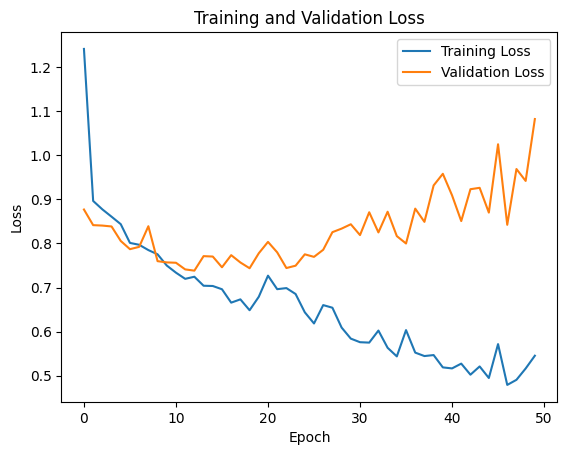

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 27562308 (105.14 MB)
Trainable params: 12847620 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
38/38

In [42]:
train_vgg16_model()

# VGG-LSTM

In [43]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_vgg16_cnn_lstm_model():
    # Load pre-trained VGG16 model without top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for classification
    vgg16_model = base_model.output
    vgg16_model = Flatten()(vgg16_model)
    vgg16_model = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(vgg16_model)
    vgg16_model = Dropout(0.6)(vgg16_model)
    vgg16_model = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(vgg16_model)
    vgg16_model = Dropout(0.6)(vgg16_model)

    # Add CNN-LSTM layers
    cnn_lstm_model = Reshape((1, 512))(vgg16_model)
    cnn_lstm_model = LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01))(cnn_lstm_model) #L2
    cnn_lstm_model = Dropout(0.6)(cnn_lstm_model)
    cnn_lstm_model = LSTM(256, kernel_regularizer=l2(0.01))(cnn_lstm_model)
    cnn_lstm_model = Dropout(0.6)(cnn_lstm_model)

    # Add output layer
    num_classes = 4  # 클래스 개수 설정
    output = Dense(num_classes, activation='softmax')(cnn_lstm_model)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile model
    optimizer = Adam(lr=5.520238899015578e-05)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Fine-tuning: Unfreeze some layers and train the entire model with new data
    for layer in model.layers:
        if 'block4' in layer.name or 'block5' in layer.name:  # Unfreeze layers starting from 'block4'
            layer.trainable = True

    # Define early stopping callback
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Train the model with early stopping and data augmentation
    batch_size = 16
    train_generator = train_datagen.flow(X_train, y_train_one_hot, batch_size=batch_size)
    steps_per_epoch = len(X_train) // batch_size

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=(X_val, y_val_one_hot),
        epochs=50
    )

    # Plot training history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Evaluate the model
    model.summary()
    val_loss, val_acc = model.evaluate(X_val, y_val_one_hot)
    print('val accuracy:', val_acc)
    test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
    print('Test accuracy:', test_acc)

Epoch 1/50
350/350 [==============================] - 64s 169ms/step - loss: 3.4843 - accuracy: 0.2495 - val_loss: 1.4711 - val_accuracy: 0.2358
Epoch 2/50
350/350 [==============================] - 57s 164ms/step - loss: 1.4120 - accuracy: 0.2484 - val_loss: 1.3920 - val_accuracy: 0.2358
Epoch 3/50
350/350 [==============================] - 57s 164ms/step - loss: 1.3885 - accuracy: 0.2550 - val_loss: 1.3876 - val_accuracy: 0.2358
Epoch 4/50
350/350 [==============================] - 58s 165ms/step - loss: 1.3870 - accuracy: 0.2504 - val_loss: 1.3869 - val_accuracy: 0.2383
Epoch 5/50
350/350 [==============================] - 58s 164ms/step - loss: 1.3867 - accuracy: 0.2516 - val_loss: 1.3872 - val_accuracy: 0.2358
Epoch 6/50
350/350 [==============================] - 58s 165ms/step - loss: 1.3867 - accuracy: 0.2502 - val_loss: 1.3886 - val_accuracy: 0.2358
Epoch 7/50
350/350 [==============================] - 58s 164ms/step - loss: 1.3867 - accuracy: 0.2543 - val_loss: 1.3880 - val_ac

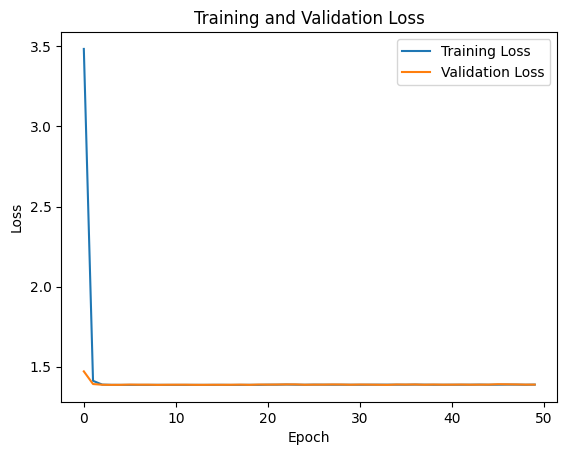

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [44]:
train_vgg16_cnn_lstm_model()